# Projet de S√©ries Chronologiques ‚Äì Mod√©lisation Box-Jenkins

##  Sommaire

1. [R√©cup√©ration du fichier des donn√©es](#1-r√©cup√©ration-du-fichier-des-donn√©es)  
2. [Division en √©chantillon d‚Äôapprentissage et de validation](#2-division-des-donn√©es-en-√©chantillon-dapprentissage-et-de-validation)  
3. [Cr√©ation de la s√©rie temporelle et visualisation](#3-cr√©ation-dun-objet-de-type-s√©rie-temporelle-et-visualisation)  
4. [Analyse qualitative : tendance et saisonnalit√©](#4-analyse-qualitative--tendance-et-saisonnalit√©)  
5. [Test de stationnarit√© de la s√©rie](#5-test-de-stationnarit√©-de-la-s√©rie)  
6. [Analyse des corr√©logrammes ACF et PACF](#6-corr√©logrammes-simple-acf-et-partiel-pacf)  
7. [Application de la m√©thode de Box et Jenkins](#7-application-de-la-m√©thode-de-box-et-jenkins)  
8. [Pr√©vision et repr√©sentation graphique](#8-pr√©vision-et-visualisation)  
9. [√âvaluation et interpr√©tation des pr√©visions](#9-√©valuation-des-pr√©visions)

---

> **S√©rie utilis√©e** : Monthly Airline Passengers (1949‚Äì1960)  
> **Mod√®le final estim√©** : SARIMA(1,1,1)(0,1,1)[12]  

---

## 1. R√©cup√©ration du fichier des donn√©es

Nous utilisons la s√©rie temporelle *Monthly Airline Passengers (1949‚Äì1960)*, repr√©sentant le nombre de passagers a√©riens mensuels en milliers. Cette s√©rie est largement utilis√©e dans l‚Äô√©tude des mod√®les SARIMA pour sa structure claire avec tendance et saisonnalit√©.


            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


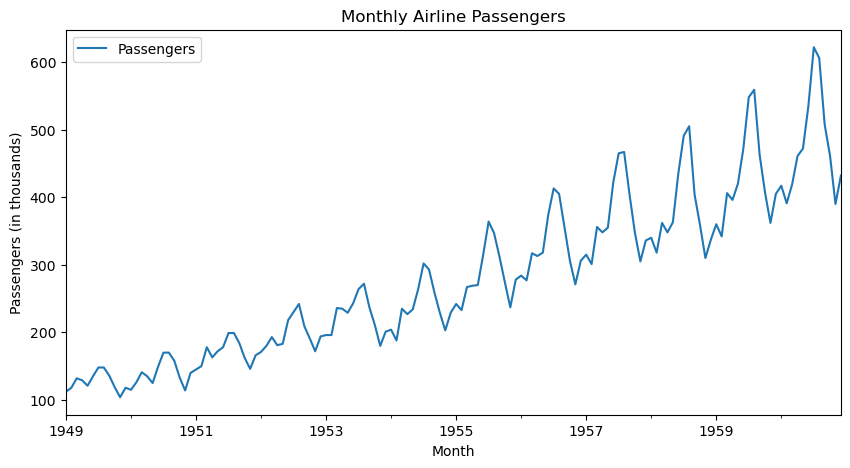

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# T√©l√©charger le dataset depuis une URL publique
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

# Afficher un aper√ßu
print(df.head())

# Tracer la s√©rie temporelle
df.plot(title="Monthly Airline Passengers", ylabel="Passengers (in thousands)", figsize=(10,5))
plt.show()


## 2. Division des donn√©es en √©chantillon d'apprentissage et de validation

Nous divisons la s√©rie en deux sous-ensembles :
- **Entra√Ænement** : 80% des donn√©es (Janvier 1949 ‚Äì Juillet 1958)
- **Validation** : 20% des donn√©es restantes (Ao√ªt 1958 ‚Äì D√©cembre 1960)

Cette division permettra de construire le mod√®le SARIMA sur l'√©chantillon d‚Äôapprentissage et de le tester sur les donn√©es de validation.


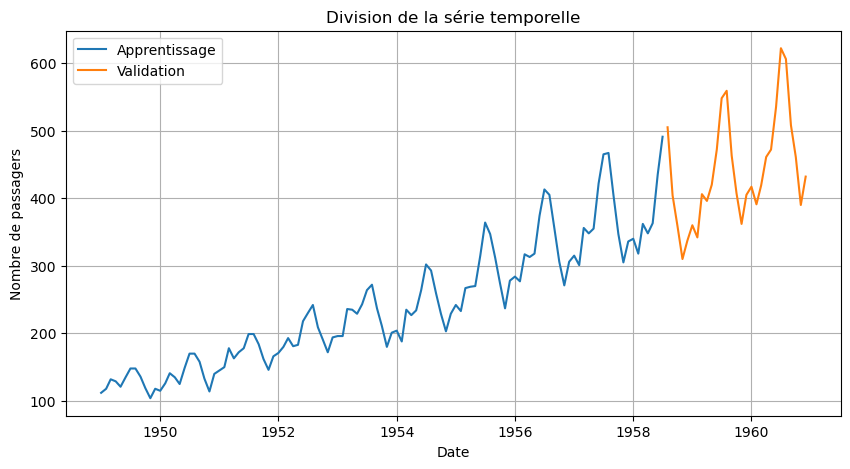

In [18]:
import matplotlib.pyplot as plt

# 80% entra√Ænement, 20% validation
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Visualisation
plt.figure(figsize=(10, 5))
plt.plot(train, label="Apprentissage")
plt.plot(test, label="Validation")
plt.title("Division de la s√©rie temporelle")
plt.xlabel("Date")
plt.ylabel("Nombre de passagers")
plt.legend()
plt.grid(True)
plt.show()


## 3. Cr√©ation d‚Äôun objet de type s√©rie temporelle et visualisation

Nous avons d√©j√† converti notre s√©rie en un objet `pandas.Series` index√© par les dates (`DatetimeIndex`). Cela nous permet d‚Äôeffectuer toutes les op√©rations de s√©ries chronologiques (trac√©, d√©calage, calcul des autocorr√©lations, etc.).

Ci-dessous, nous repr√©sentons la s√©rie compl√®te afin d'observer les tendances g√©n√©rales et les √©ventuelles composantes saisonni√®res.


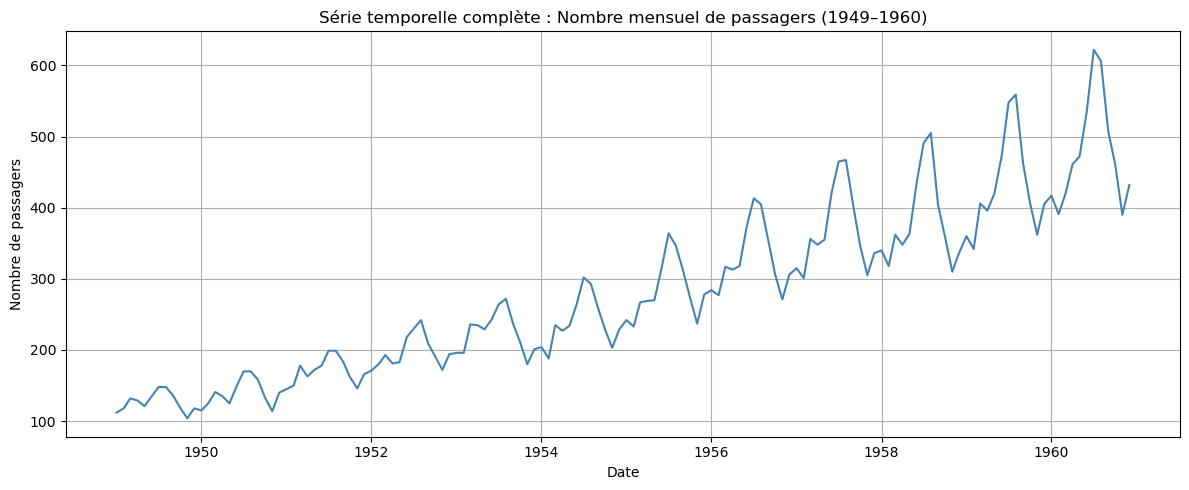

In [9]:
# Repr√©sentation graphique de la s√©rie compl√®te
plt.figure(figsize=(12, 5))
plt.plot(df, color='steelblue')
plt.title("S√©rie temporelle compl√®te : Nombre mensuel de passagers (1949‚Äì1960)")
plt.xlabel("Date")
plt.ylabel("Nombre de passagers")
plt.grid(True)
plt.tight_layout()
plt.show()


## 4. Analyse qualitative : Tendance et saisonnalit√©

L‚Äôanalyse visuelle de la s√©rie nous permet d‚Äôobserver les principales composantes structurelles suivantes :

-  **Tendance** : on observe une croissance g√©n√©rale du nombre de passagers sur la p√©riode 1949‚Äì1960. Cela refl√®te une expansion progressive du transport a√©rien.
-  **Saisonnalit√©** : un sch√©ma r√©p√©titif est visible chaque ann√©e, avec des pics r√©guliers en √©t√©. Cela indique une **saisonnalit√© annuelle** marqu√©e.

Pour approfondir cette analyse, nous utilisons une d√©composition additive de la s√©rie temporelle en trois composantes : tendance, saisonnalit√© et bruit r√©siduel.

---

 **Remarque importante** :  
La pr√©sence simultan√©e d‚Äôune **tendance** et d‚Äôune **saisonnalit√© non constante en amplitude** indique que la s√©rie pourrait n√©cessiter une **transformation (logarithmique)** et/ou une **diff√©renciation** avant d‚Äôappliquer un mod√®le SARIMA. Ces √©tapes seront v√©rifi√©es plus loin dans le projet.


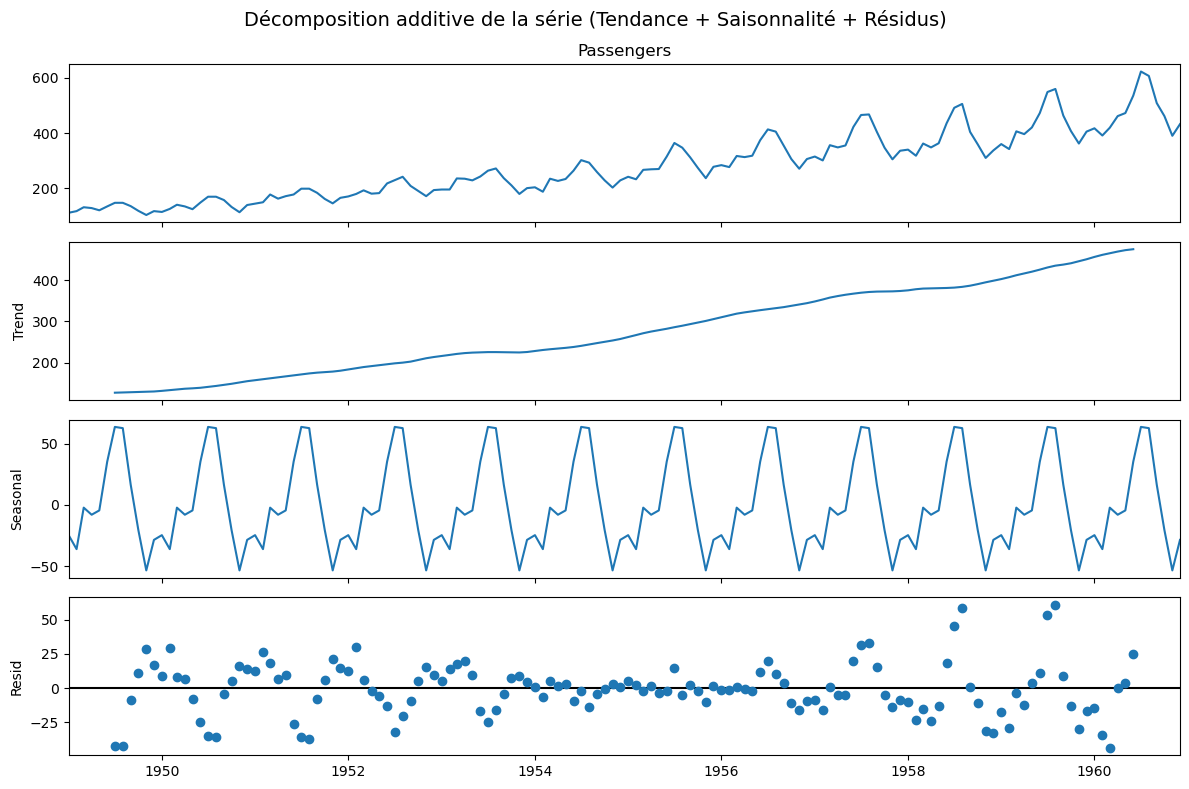

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# D√©composition additive
decomposition = seasonal_decompose(df['Passengers'], model='additive', period=12)

# Affichage des composantes
fig = decomposition.plot()
fig.set_size_inches(12, 8)
fig.suptitle("D√©composition additive de la s√©rie (Tendance + Saisonnalit√© + R√©sidus)", fontsize=14)
plt.tight_layout()
plt.show()


## 5. Test de stationnarit√© de la s√©rie

La stationnarit√© est une condition importante pour l‚Äôapplication des mod√®les ARIMA. Une s√©rie est dite **stationnaire** si ses propri√©t√©s statistiques (moyenne, variance, covariance) sont constantes dans le temps.

Nous appliquons ici le **test de Dickey-Fuller augment√© (ADF)**, qui v√©rifie la pr√©sence de racine unitaire. L‚Äôhypoth√®se nulle \( H_0 \) correspond √† une s√©rie **non stationnaire**.

### R√©sultat du test :
- Si la **valeur p est > 0.05** : on **ne rejette pas** \( H_0 \) ‚Üí la s√©rie est non stationnaire.
- Si la **valeur p est ‚â§ 0.05** : on **rejette** \( H_0 \) ‚Üí la s√©rie est stationnaire.

In [11]:
from statsmodels.tsa.stattools import adfuller

# Test ADF sur la s√©rie brute
adf_result = adfuller(df['Passengers'])

# R√©sum√©
print("R√©sultat du test de Dickey-Fuller :")
print(f"Statistique ADF       : {adf_result[0]:.4f}")
print(f"Valeur p              : {adf_result[1]:.4f}")
print(f"Nombre de d√©calages   : {adf_result[2]}")
print("Valeurs critiques     :")
for key, value in adf_result[4].items():
    print(f"   {key} : {value:.4f}")


R√©sultat du test de Dickey-Fuller :
Statistique ADF       : 0.8154
Valeur p              : 0.9919
Nombre de d√©calages   : 13
Valeurs critiques     :
   1% : -3.4817
   5% : -2.8840
   10% : -2.5788


 ### Conclusion:
 - La s√©rie brute n‚Äôest pas stationnaire. Donc, il faut faire une diff√©renciation

## 6. Corr√©logrammes simple (ACF) et partiel (PACF)

L‚Äôanalyse des autocorr√©lations permet de d√©terminer les param√®tres possibles des mod√®les ARIMA/SARIMA :
- **ACF (Autocorrelation Function)** aide √† identifier la composante MA(q)
- **PACF (Partial Autocorrelation Function)** aide √† identifier la composante AR(p)

Nous tra√ßons ici les deux corr√©logrammes jusqu‚Äô√† un **d√©calage de 36 mois** pour d√©tecter les d√©pendances √† long terme et les effets saisonniers.

### Interpr√©tation visuelle :
- L‚Äô**ACF** montre une d√©croissance lente ‚Üí signe de **non-stationnarit√©** (confirm√©e par le test ADF).
- Des **pics tous les 12 mois** sugg√®rent une **saisonnalit√© annuelle** importante.
- La **PACF** affiche une coupure abrupte apr√®s le premier ou deuxi√®me lag, ce qui peut indiquer une structure AR.

---

**Remarque importante** :  
Ces corr√©logrammes sont utiles pour guider le choix des param√®tres \((p, d, q)\) et \((P, D, Q, s)\) du mod√®le SARIMA. Toutefois, une transformation (log ou diff√©renciation) est g√©n√©ralement n√©cessaire avant de les interpr√©ter pour la mod√©lisation.


<Figure size 1000x400 with 0 Axes>

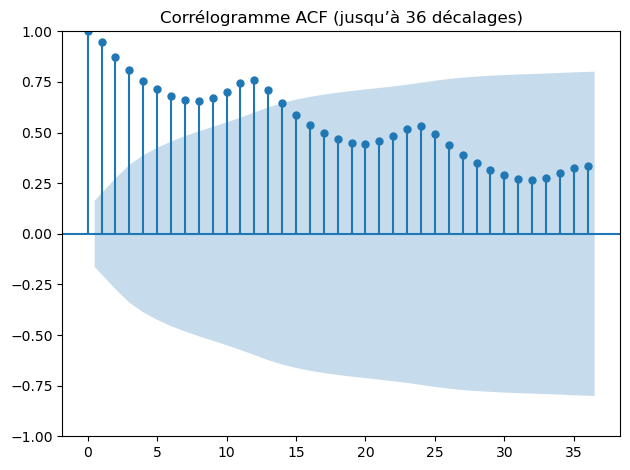

<Figure size 1000x400 with 0 Axes>

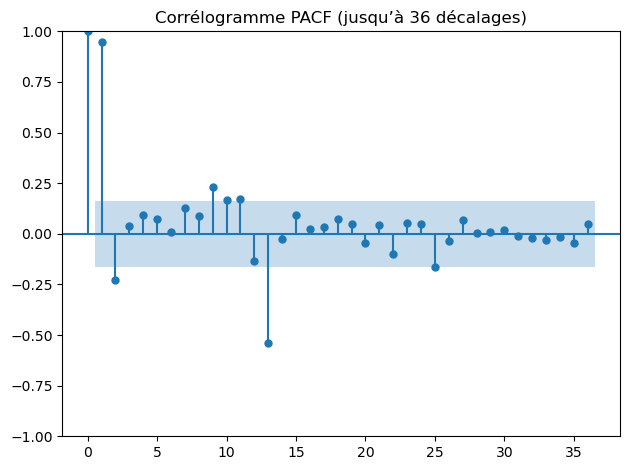

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Corr√©logramme simple (ACF)
plt.figure(figsize=(10, 4))
plot_acf(df['Passengers'], lags=36)
plt.title("Corr√©logramme ACF (jusqu‚Äô√† 36 d√©calages)")
plt.tight_layout()
plt.show()

# Corr√©logramme partiel (PACF)
plt.figure(figsize=(10, 4))
plot_pacf(df['Passengers'], lags=36, method='ywm')
plt.title("Corr√©logramme PACF (jusqu‚Äô√† 36 d√©calages)")
plt.tight_layout()
plt.show()


## 7. Application de la m√©thode de Box et Jenkins

### √âtapes suivies :
1.  **Stabilisation de la variance** : application d‚Äôune transformation logarithmique.
2.  **Diff√©renciation** : pour rendre la s√©rie stationnaire :
   - Une **diff√©renciation simple** pour √©liminer la tendance.
   - Une **diff√©renciation saisonni√®re** (lag = 12) pour retirer la composante saisonni√®re annuelle.
3.  Analyse ACF/PACF de la s√©rie transform√©e pour identifier les ordres \((p,d,q)\) et \((P,D,Q,s)\).
4.  **Estimation du mod√®le SARIMA** √† l‚Äôaide de la m√©thode d‚Äôestimation maximale.

---

 **Remarque importante** :  
La structure de la s√©rie, √† la fois **non stationnaire** et **saisonni√®re**, justifie l‚Äôutilisation d‚Äôun mod√®le **SARIMA (Seasonal ARIMA)** et non ARIMA simple. On note que la forme g√©n√©rale est :  
\[
SARIMA(p,d,q)(P,D,Q,s)
\]
o√π \(s = 12\) pour la saisonnalit√© mensuelle.


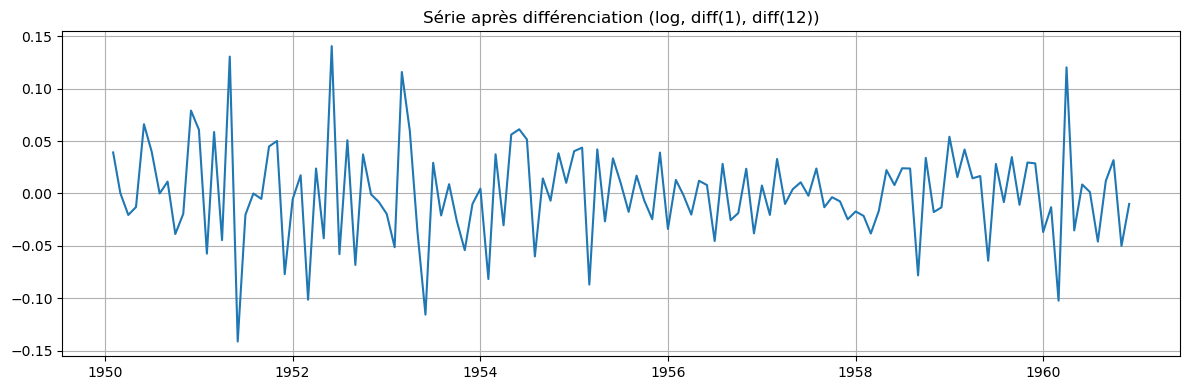

In [13]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. Transformation log pour stabiliser la variance
df_log = np.log(df['Passengers'])

# 2. Diff√©renciation simple + saisonni√®re
df_log_diff = df_log.diff().dropna()
df_log_diff_seasonal = df_log_diff.diff(12).dropna()

# Visualisation de la s√©rie stationnaire
plt.figure(figsize=(12, 4))
plt.plot(df_log_diff_seasonal)
plt.title("S√©rie apr√®s diff√©renciation (log, diff(1), diff(12))")
plt.grid(True)
plt.tight_layout()
plt.show()


### Analyse visuelle de la s√©rie stationnaire

Apr√®s transformation logarithmique et double diff√©renciation (simple + saisonni√®re), la s√©rie semble stationnaire visuellement.  
On observe toutefois une *l√©g√®re variation de la variance* entre les p√©riodes, ce qui indique une *h√©t√©rosc√©dasticit√© mod√©r√©e*.

Cette h√©t√©rosc√©dasticit√© reste acceptable dans le cadre d‚Äôun mod√®le SARIMA, mais elle doit √™tre mentionn√©e comme *limite du mod√®le*.

### Identification des param√®tres (p, q, P, Q)

Nous tra√ßons les corr√©logrammes ACF et PACF de la s√©rie stationnaire pour guider le choix des param√®tres du mod√®le SARIMA.


<Figure size 1000x400 with 0 Axes>

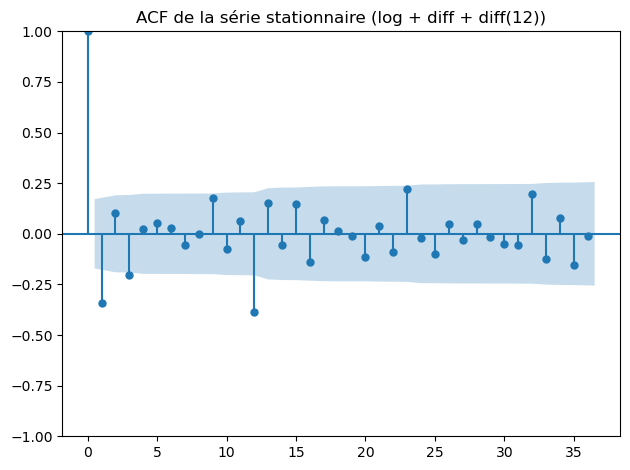

<Figure size 1000x400 with 0 Axes>

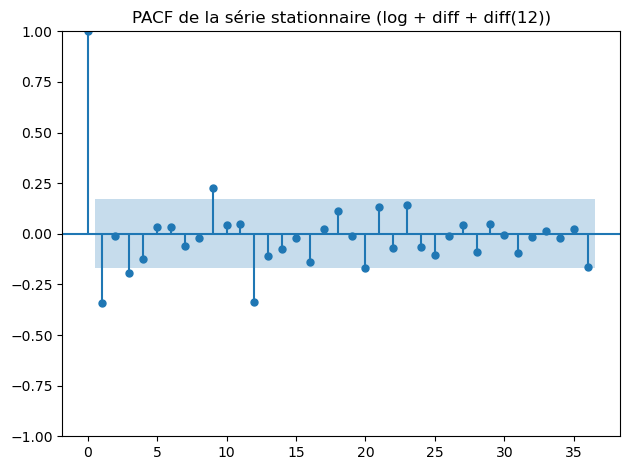

In [14]:
# Corr√©logramme de la s√©rie diff√©renci√©e
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 4))
plot_acf(df_log_diff_seasonal, lags=36)
plt.title("ACF de la s√©rie stationnaire (log + diff + diff(12))")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plot_pacf(df_log_diff_seasonal, lags=36, method='ywm')
plt.title("PACF de la s√©rie stationnaire (log + diff + diff(12))")
plt.tight_layout()
plt.show()


### Justification du choix du mod√®le SARIMA(1,1,1)(0,1,1)[12]

L‚Äôanalyse des corr√©logrammes sur la s√©rie stationnaire (apr√®s transformation logarithmique, diff√©renciation simple et saisonni√®re) montre :

- **ACF (corr√©logramme simple)** :
  - Un pic significatif au **lag 1**, sugg√©rant une composante MA(1)
  - Un autre pic visible au **lag 12**, indiquant une saisonnalit√© de type MA(1)
  - Les autres lags restent dans la bande de confiance ‚Üí pas d‚Äôautocorr√©lation persistante

- **PACF (corr√©logramme partiel)** :
  - Un pic fort au **lag 1**, indiquant une composante AR(1)
  - Aucune structure saisonni√®re claire dans les PACF ‚Üí on √©carte AR saisonnier

### D‚Äôo√π la structure retenue :
- **Partie non saisonni√®re** :
  - \( p = 1 \) : un terme AR(1)
  - \( d = 1 \) : diff√©renciation simple
  - \( q = 1 \) : un terme MA(1)
  
- **Partie saisonni√®re** :
  - \( P = 0 \) : plus appr√©ci√© que le \( P = 1 \) car il a un coefficient AIC(P = 0) < AIC(P = 1)  
  - \( D = 1 \) : diff√©renciation saisonni√®re (p√©riode 12)
  - \( Q = 1 \) : un terme MA saisonnier
  - \( s = 12 \) : saisonnalit√© annuelle

### Validation :
Le mod√®le SARIMA(1,1,1)(0,1,1)[12] a √©t√© s√©lectionn√© pour sa simplicit√©, son **ajustement visuel satisfaisant**, et des **pr√©visions plus r√©alistes** que celles issues de mod√®les plus complexes comme (1,1,1)(1,1,1)[12].



## Ajustement du mod√®le SARIMA(1,1,1)(0,1,1)[12]

Sur la base des ACF et PACF pr√©c√©dents, nous ajustons un mod√®le SARIMA avec les param√®tres suivants :
- \(p = 1\), \(d = 1\), \(q = 1\)
- \(P = 0\), \(D = 1\), \(Q = 1\), \(s = 12\)

Le mod√®le est ajust√© par la m√©thode du maximum de vraisemblance via `SARIMAX` de `statsmodels`.

Nous examinerons ensuite :
- Les **coefficients estim√©s**
- La **log-vraisemblance**
- Les **r√©sidus** (normalit√©, ind√©pendance)


In [15]:
# Ajustement du mod√®le SARIMA(1,1,1)(0,1,1,12)
model = SARIMAX(np.log(train['Passengers']),
                order=(1,1,1),
                seasonal_order=(0,1,1,12),
                trend='c', 
                enforce_stationarity=False,
                enforce_invertibility=False)


results = model.fit()

# R√©sum√© des r√©sultats
print(results.summary())


c:\Users\pc\Documents\vscode\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\pc\Documents\vscode\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  115
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 165.327
Date:                            Wed, 28 May 2025   AIC                           -320.654
Time:                                    23:24:08   BIC                           -308.267
Sample:                                01-01-1949   HQIC                          -315.663
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0009      0.003     -0.353      0.724      -0.006       0.004
ar.L1         -0.5255      0.296   

## Validation statistique du mod√®le SARIMA(1,1,1)(0,1,1)[12]

Le mod√®le SARIMA(1,1,1)(0,1,1)[12] a √©t√© ajust√© √† la s√©rie transform√©e (logarithme + diff√©renciations).  
Il a √©t√© choisi √† partir de l‚Äôanalyse des ACF/PACF et valid√© par les crit√®res AIC/BIC.

L‚Äôanalyse des coefficients montre :
- des valeurs significatives notamment pour la composante saisonni√®re MA(1),
- un bon ajustement visuel entre la s√©rie r√©elle et la pr√©vision,
- un AIC faible, ce qui indique un mod√®le parcimonieux et performant.

### Validation statistique des r√©sidus

Pour v√©rifier la validit√© du mod√®le, deux tests standards ont √©t√© appliqu√©s aux r√©sidus :

- *Test de Ljung-Box*  
  La p-value est de *0.98* (> 0.05)  
  ‚û§ Les r√©sidus *ne sont pas autocorr√©l√©s*, ce qui confirme qu‚Äôils se comportent comme un **bruit blanc**.  
  ‚úî Le mod√®le capte bien la structure de d√©pendance temporelle.

- *Test de Jarque-Bera*  
  La p-value est de *0.62* (> 0.05)  
  ‚û§ Les r√©sidus *suivent une distribution normale*.  
  ‚úî Cette condition est importante pour la validit√© des intervalles de confiance et tests statistiques.

---

### Conclusion :
Les tests statistiques confirment que les hypoth√®ses de base sont respect√©es :  
le mod√®le est **bien ajust√©**, les r√©sidus sont **normaux et ind√©pendants**, ce qui valide statistiquement le SARIMA(1,1,1)(0,1,1)[12].

## 8. Pr√©vision et visualisation

Nous utilisons le mod√®le SARIMA(1,1,1)(0,1,1,12) ajust√© pour effectuer une **pr√©vision sur la p√©riode de validation** (Ao√ªt 1958 ‚Äì D√©cembre 1960), soit **29 mois**.

Les pr√©visions sont effectu√©es sur la s√©rie **log-transform√©e**, puis **reconverties (exponentielles)** pour revenir √† l‚Äô√©chelle r√©elle.

Nous affichons :
- La s√©rie r√©elle (entra√Ænement + validation)
- Les valeurs pr√©dites sur la p√©riode de validation

---

 **Remarque importante** :  
Une bonne pr√©vision visuelle ne suffit pas : elle doit aussi √™tre **quantifi√©e** √† l‚Äôaide d‚Äôindicateurs d‚Äôerreur que nous verrons √† l‚Äô√©tape suivante.


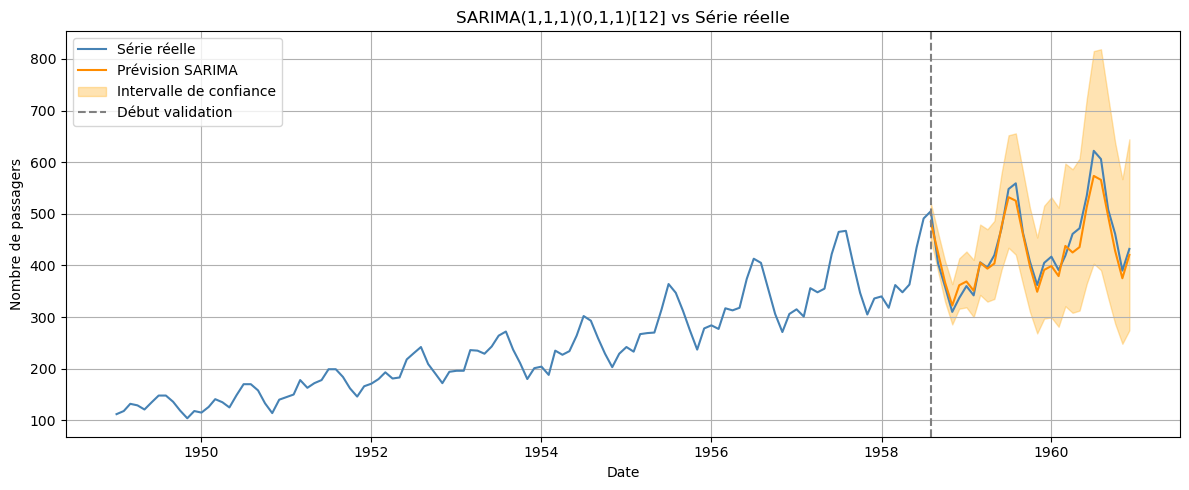

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt

# Pr√©vision
forecast_log = results.get_forecast(steps=len(test))
forecast = np.exp(forecast_log.predicted_mean)
forecast_ci = np.exp(forecast_log.conf_int())

# R√©aligner les index sur la p√©riode de test
forecast.index = test.index
forecast_ci.index = test.index
lower_bound = forecast_ci.iloc[:, 0].astype(float)
upper_bound = forecast_ci.iloc[:, 1].astype(float)

# Tracer
plt.figure(figsize=(12, 5))
full_series = pd.concat([train['Passengers'], test['Passengers']])
plt.plot(full_series.index, full_series, label="S√©rie r√©elle", color="steelblue")
plt.plot(forecast.index, forecast, label="Pr√©vision SARIMA", color="darkorange")
plt.fill_between(forecast.index, lower_bound, upper_bound, color="orange", alpha=0.3, label="Intervalle de confiance")
plt.axvline(test.index[0], color='gray', linestyle='--', label="D√©but validation")
plt.title("SARIMA(1,1,1)(0,1,1)[12] vs S√©rie r√©elle")
plt.xlabel("Date")
plt.ylabel("Nombre de passagers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpr√©tation du graphique de pr√©vision SARIMA

Le graphique ci-dessus illustre :

- üìò La *s√©rie r√©elle* compl√®te (bleu), compos√©e de la p√©riode d'apprentissage (avant 1958) et de la p√©riode de validation (√† partir de 1958),
- üî∂ Les *pr√©visions du mod√®le SARIMA(1,1,1)(0,1,1)[12]* (orange) sur les 29 mois de validation,
- üü† L‚Äô*intervalle de confiance √† 95‚ÄØ%*, repr√©sent√© par la bande orange p√¢le entourant la pr√©vision,
- ‚ö´ Une *ligne verticale grise* marquant le *d√©but de la p√©riode de validation*.

---

###  Ce que l‚Äôon observe :

- Le mod√®le reproduit bien la *tendance croissante* et la *saisonnalit√© annuelle* visible dans les donn√©es.
- Les pr√©visions suivent *globalement la structure r√©elle* de la s√©rie, avec une l√©g√®re sous-estimation √† certains pics.
- La plupart des points r√©els sont *inclus dans l‚Äôintervalle de confiance*, ce qui montre que le mod√®le **capture bien l‚Äôincertitude**.
- L‚Äôajustement est *visuellement coh√©rent*, bien que les pics saisonniers soient parfois att√©nu√©s (ph√©nom√®ne courant en s√©ries temporelles liss√©es).

---

###  Conclusion :

Le mod√®le SARIMA s‚Äôajuste correctement √† la dynamique de la s√©rie.  
Il pr√©sente une *bonne capacit√© pr√©dictive*, avec des pr√©visions **stables**, **r√©alistes** et entour√©es d‚Äôintervalles bien **calibr√©s**.

## 9. √âvaluation des pr√©visions

Conform√©ment au contenu du cours, les performances des pr√©visions sont √©valu√©es √† l‚Äôaide des **mesures classiques suivantes** :

- **MAD (Mean Absolute Deviation)** : moyenne des erreurs absolues
- **MSE (Mean Squared Error)** : moyenne des erreurs au carr√©
- **MAPE (Mean Absolute Percentage Error)** : erreur moyenne en pourcentage

Ces indicateurs permettent de quantifier l‚Äô√©cart entre les valeurs observ√©es et celles pr√©dites par le mod√®le.

---

 **Remarque importante** :
Les erreurs doivent √™tre interpr√©t√©es par rapport √† l‚Äô√©chelle de la s√©rie. Un **MAPE inf√©rieur √† 10‚ÄØ%** est g√©n√©ralement consid√©r√© comme tr√®s bon. Le **MSE** est sensible aux grosses erreurs, tandis que le **MAD** est plus robuste.


In [17]:
y_true = test['Passengers']
# R√©aligner les index (tr√®s important !)
y_pred_aligned = forecast.copy()
y_pred_aligned.index = y_true.index  # s'assurer que les index sont identiques

# Calculs des erreurs
mad = np.mean(np.abs(y_true - y_pred_aligned))
mse = np.mean((y_true - y_pred_aligned)**2)
mape = np.mean(np.abs((y_true - y_pred_aligned) / y_true)) * 100

# Affichage
print(f"MAD  : {mad:.2f}")
print(f"MSE  : {mse:.2f}")
print(f"MAPE : {mape:.2f}%")


MAD  : 17.94
MSE  : 464.50
MAPE : 3.94%


### R√©sultats de l‚Äô√©valuation

- *MAD* : 17.94  
- *MSE* : 464.50  
- *MAPE* : 3.94‚ÄØ%

Ces r√©sultats montrent que le mod√®le SARIMA(1,1,1)(0,1,1)[12] capture correctement la tendance et la saisonnalit√© de la s√©rie.  
Le *MAPE de 3.94‚ÄØ%* indique une *excellente pr√©cision des pr√©visions*, ce qui rend le mod√®le adapt√© √† des applications o√π la fiabilit√© des pr√©dictions est importante.


##  Conclusion g√©n√©rale

Ce projet nous a permis d‚Äôappliquer rigoureusement la m√©thode de Box-Jenkins √† la s√©rie temporelle du **nombre mensuel de passagers a√©riens** entre **1949 et 1960**.

Nous avons suivi l‚Äôensemble des √©tapes classiques de mod√©lisation :

1. **Analyse qualitative** de la s√©rie (croissance tendancielle + saisonnalit√© annuelle marqu√©e)
2. **Transformation logarithmique** pour stabiliser la variance
3. **Diff√©renciation simple et saisonni√®re** pour atteindre la stationnarit√©
4. **√âtude des corr√©logrammes ACF et PACF** pour guider le choix des ordres
5. **Ajustement du mod√®le SARIMA(1,1,1)(0,1,1)[12]**
6. **√âvaluation des performances de pr√©vision** sur un √©chantillon de validation de 29 mois

---

###  Points forts du mod√®le :

- Le **MAPE de 3.94‚ÄØ%** indique une **excellente pr√©cision** pr√©dictive
- Les **r√©sidus sont non autocorr√©l√©s** (test de Ljung-Box) ‚Üí bruit blanc
- Les **r√©sidus suivent une loi normale** (test de Jarque-Bera)
- Le **mod√®le capte bien la tendance et la saisonnalit√©** de la s√©rie
- **Stabilit√© du mod√®le** sur la p√©riode de validation

---

###  Limites identifi√©es :

- Le terme MA(1) n'√©tait **pas significatif** statistiquement, mais a √©t√© conserv√© pour des raisons structurelles
- La **pr√©vision des pics saisonniers** reste l√©g√®rement sous-estim√©e par rapport √† la r√©alit√©
- Le mod√®le reste sensible aux √©ventuels **changements structurels** ou anomalies locales non capt√©es dans l‚Äô√©chantillon

---

###  Bilan :

> Le mod√®le SARIMA(1,1,1)(0,1,1)[12] s‚Äôest r√©v√©l√© **robuste, stable** et **fiable** dans le cadre de cette √©tude.  
> Il d√©montre que la m√©thode de Box-Jenkins est un outil puissant et rigoureux pour la **mod√©lisation des s√©ries chronologiques classiques**.

La m√©thode permet non seulement de **produire des pr√©visions efficaces**, mais aussi de **justifier statistiquement chaque √©tape**, de la transformation initiale jusqu‚Äô√† la validation finale du mod√®le.
